In [88]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['font.sans-serif'] = ['SimHei']  

### 1. Collect Data

In [89]:
# Set up the ticker and the date range
ticker_symbol = "META"
start_date = "2021-01-01"
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

# Fetch the data
stock_data = yf.download(ticker_symbol,start=start_date, end=end_date)
stock_data.tail(6)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-31,323.690002,325.660004,317.589996,318.600006,318.600006,25799600
2023-08-01,317.540009,324.140015,314.660004,322.709991,322.709991,22817900
2023-08-02,318.000000,318.390015,310.649994,314.309998,314.309998,20461100
2023-08-03,309.929993,315.950012,309.929993,313.190002,313.190002,15180200
2023-08-04,314.959991,318.410004,310.200012,310.730011,310.730011,17600200
2023-08-07,313.230011,317.070007,310.480011,316.559998,316.559998,16190466


In [90]:
# Calculate SMA and CCI
stock_data["SMA_5"] = ta.sma(stock_data['Close'], length=5)
stock_data["CCI_20"] = ta.cci(stock_data['High'], stock_data['Low'], stock_data['Close'], length=20)

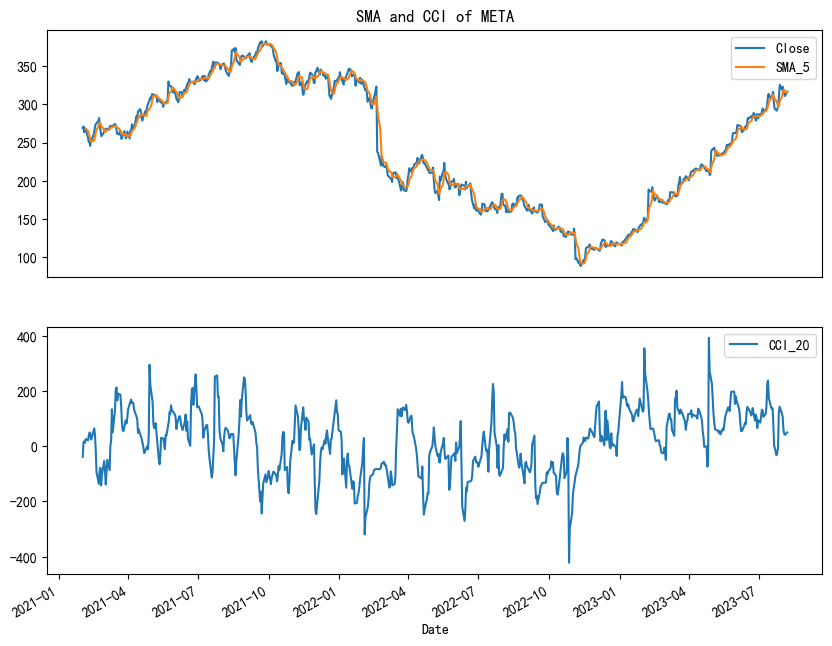

In [91]:
# Plot sma and cci of META
plt.subplot(2,1,1)
plt.title("SMA and CCI of META")
plt.gca().axes.get_xaxis().set_visible(False)
stock_data['Close'].plot(figsize = (10,8))
stock_data['SMA_5'].plot(figsize=(10,8))
plt.legend()
plt.subplot(2,1,2)
stock_data['CCI_20'].plot(figsize = (10,8))
plt.legend()
plt.show()

### 2. Trading Signals and Logics

In [92]:
# To generate selling/buying signals, we should use the data of yesterday and before yesterday
stock_data['yesterday_close'] = stock_data['Close'].shift(1)
stock_data['yesterday_sma'] = stock_data['SMA_5'].shift(1)
stock_data['yesterday_cci'] = stock_data['CCI_20'].shift(1)   # CCI is a filter for ths strategy
stock_data['daybeforeyes_close'] = stock_data['Close'].shift(2)
stock_data['daybeforeyes_sma'] = stock_data['SMA_5'].shift(2)

stock_data.tail(9)

,Open,High,Low,Close,Adj Close,Volume,SMA_5,CCI_20,yesterday_close,yesterday_sma,yesterday_cci,daybeforeyes_close,daybeforeyes_sma
Date,,,,,,,,,,,,,
2023-07-26,301.190002,301.769989,291.899994,298.570007,298.570007,47256900,296.285999,-6.651076,294.470001,299.773999,-21.043475,291.609985,303.289996
2023-07-27,325.119995,325.350006,309.839996,311.709991,311.709991,64229200,298.123999,117.898102,298.570007,296.285999,-6.651076,294.470001,299.773999
2023-07-28,316.880005,326.200012,314.250000,325.480011,325.480011,39220300,304.367999,142.988491,311.709991,298.123999,117.898102,298.570007,296.285999
2023-07-31,323.690002,325.660004,317.589996,318.600006,318.600006,25799600,309.766003,118.941100,325.480011,304.367999,142.988491,311.709991,298.123999
2023-08-01,317.540009,324.140015,314.660004,322.709991,322.709991,22817900,315.414001,108.116128,318.600006,309.766003,118.941100,325.480011,304.367999
2023-08-02,318.000000,318.390015,310.649994,314.309998,314.309998,20461100,318.562000,60.462562,322.709991,315.414001,108.116128,318.600006,309.766003
2023-08-03,309.929993,315.950012,309.929993,313.190002,313.190002,15180200,318.858002,45.331607,314.309998,318.562000,60.462562,322.709991,315.414001
2023-08-04,314.959991,318.410004,310.200012,310.730011,310.730011,17600200,315.908002,41.061113,313.190002,318.858002,45.331607,314.309998,318.562000
2023-08-07,313.230011,317.070007,310.480011,316.559998,316.559998,16190466,315.500000,49.774977,310.730011,315.908002,41.061113,313.190002,318.858002


In [93]:
# Generate Trading Signals

# Buying Signal from SMA ==> '1'  Holding Signal is '0'
# Yesterday Close Price > Yesterday SMA AND DayBeforeYes Price < DayBeforeYes SMA  ==> Price Up Piercing SMA
stock_data['sma_signal'] = np.where(np.logical_and(stock_data['daybeforeyes_close']<stock_data['daybeforeyes_sma'],
                                                              stock_data['yesterday_close']>stock_data['yesterday_sma']), 1, 0)

# Selling Signal from SMA ==> '-1'
# Yesterday Close Price > Yesterday SMA AND DayBeforeYes Price < DayBeforeYes SMA  ==> Price Up Piercing SMA
stock_data['sma_signal'] = np.where(np.logical_and(stock_data['daybeforeyes_close']>stock_data['daybeforeyes_sma'],
                                                              stock_data['yesterday_close']<stock_data['yesterday_sma']), -1, stock_data['sma_signal'])

# Buying filtering signal from CCI
stock_data['cci_filter'] = np.where(stock_data['yesterday_cci']<-100, 1, 0)
# Selling filtering signal from CCI
stock_data['cci_filter'] = np.where(stock_data['yesterday_cci']>100, -1, stock_data['cci_filter'])

# Final Buying Signal
stock_data['filtered_signal'] = np.where(stock_data['sma_signal']+stock_data['cci_filter']==2, 1, 0)
# Final Selling Signal
stock_data['filtered_signal'] = np.where(stock_data['sma_signal']+stock_data['cci_filter']==-2, -1, stock_data['filtered_signal'])


In [94]:
stock_data.tail(12)

,Open,High,Low,Close,Adj Close,Volume,SMA_5,CCI_20,yesterday_close,yesterday_sma,yesterday_cci,daybeforeyes_close,daybeforeyes_sma,sma_signal,cci_filter,filtered_signal
Date,,,,,,,,,,,,,,,,
2023-07-21,304.570007,305.459991,291.200012,294.260010,294.260010,42089700,307.091998,1.992564,302.519989,310.013995,71.119394,316.010010,312.191998,-1,0,0
2023-07-24,295.779999,297.519989,288.299988,291.609985,291.609985,24915700,303.289996,-32.597370,294.260010,307.091998,1.992564,302.519989,310.013995,0,0,0
2023-07-25,295.190002,298.299988,291.859985,294.470001,294.470001,19585600,299.773999,-21.043475,291.609985,303.289996,-32.597370,294.260010,307.091998,0,0,0
2023-07-26,301.190002,301.769989,291.899994,298.570007,298.570007,47256900,296.285999,-6.651076,294.470001,299.773999,-21.043475,291.609985,303.289996,0,0,0
2023-07-27,325.119995,325.350006,309.839996,311.709991,311.709991,64229200,298.123999,117.898102,298.570007,296.285999,-6.651076,294.470001,299.773999,1,0,0
2023-07-28,316.880005,326.200012,314.250000,325.480011,325.480011,39220300,304.367999,142.988491,311.709991,298.123999,117.898102,298.570007,296.285999,0,-1,0
2023-07-31,323.690002,325.660004,317.589996,318.600006,318.600006,25799600,309.766003,118.941100,325.480011,304.367999,142.988491,311.709991,298.123999,0,-1,0
2023-08-01,317.540009,324.140015,314.660004,322.709991,322.709991,22817900,315.414001,108.116128,318.600006,309.766003,118.941100,325.480011,304.367999,0,-1,0
2023-08-02,318.000000,318.390015,310.649994,314.309998,314.309998,20461100,318.562000,60.462562,322.709991,315.414001,108.116128,318.600006,309.766003,0,-1,0


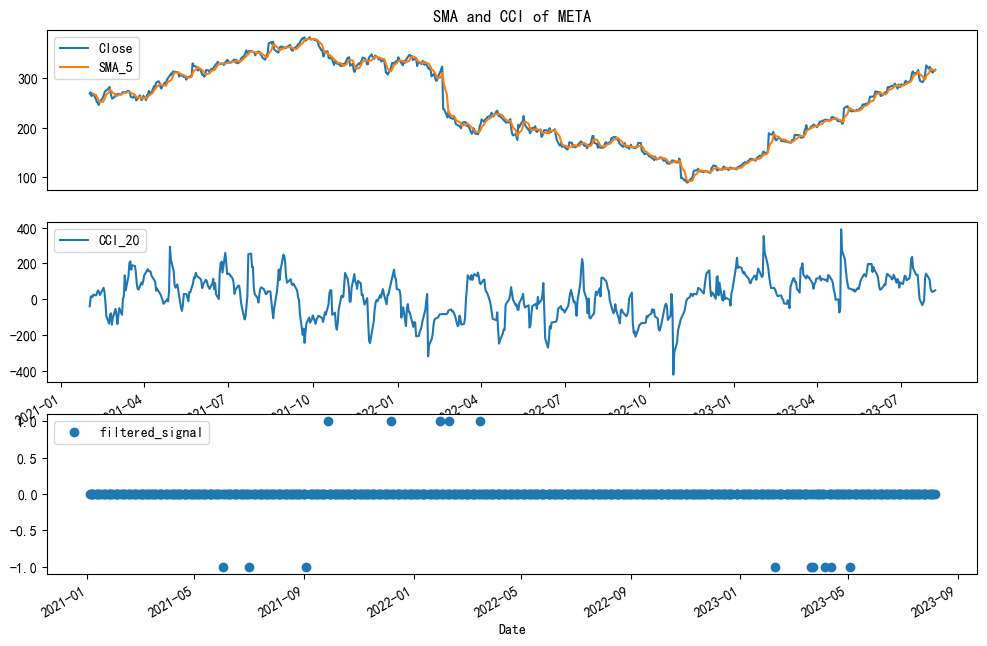

In [95]:
# Plot the upgrade
plt.subplot(3,1,1)
plt.title("SMA and CCI of META")
plt.gca().axes.get_xaxis().set_visible(False)
stock_data['Close'].plot(figsize = (12,8))
stock_data['SMA_5'].plot()
plt.legend(loc='upper left')

plt.subplot(3,1,2)
stock_data['CCI_20'].plot(figsize=(12, 8))
plt.legend(loc='upper left')

plt.subplot(3,1,3)
stock_data['filtered_signal'].plot(figsize=(12, 8), marker='o', linestyle='')
plt.legend(loc='upper left')
plt.show()
# stock_data['SMA_5'].plot(figsize=(10,8))
# plt.legend()
# plt.subplot(2,1,2)
# stock_data['CCI_20'].plot(figsize = (10,8))
# plt.legend()
# plt.show()

### 3. Position Signals

In [96]:
# Default Position is 0
position = 0
for i, item in stock_data.iterrows():
    if item['filtered_signal'] == 1:
        position = 1
    elif item['filtered_signal'] == -1:
        position = -1
    else:
        pass
    stock_data.loc[i, 'position'] = position

In [97]:
stock_data.tail(9)

,Open,High,Low,Close,Adj Close,Volume,SMA_5,CCI_20,yesterday_close,yesterday_sma,yesterday_cci,daybeforeyes_close,daybeforeyes_sma,sma_signal,cci_filter,filtered_signal,position
Date,,,,,,,,,,,,,,,,,
2023-07-26,301.190002,301.769989,291.899994,298.570007,298.570007,47256900,296.285999,-6.651076,294.470001,299.773999,-21.043475,291.609985,303.289996,0,0,0,-1.0
2023-07-27,325.119995,325.350006,309.839996,311.709991,311.709991,64229200,298.123999,117.898102,298.570007,296.285999,-6.651076,294.470001,299.773999,1,0,0,-1.0
2023-07-28,316.880005,326.200012,314.250000,325.480011,325.480011,39220300,304.367999,142.988491,311.709991,298.123999,117.898102,298.570007,296.285999,0,-1,0,-1.0
2023-07-31,323.690002,325.660004,317.589996,318.600006,318.600006,25799600,309.766003,118.941100,325.480011,304.367999,142.988491,311.709991,298.123999,0,-1,0,-1.0
2023-08-01,317.540009,324.140015,314.660004,322.709991,322.709991,22817900,315.414001,108.116128,318.600006,309.766003,118.941100,325.480011,304.367999,0,-1,0,-1.0
2023-08-02,318.000000,318.390015,310.649994,314.309998,314.309998,20461100,318.562000,60.462562,322.709991,315.414001,108.116128,318.600006,309.766003,0,-1,0,-1.0
2023-08-03,309.929993,315.950012,309.929993,313.190002,313.190002,15180200,318.858002,45.331607,314.309998,318.562000,60.462562,322.709991,315.414001,-1,0,0,-1.0
2023-08-04,314.959991,318.410004,310.200012,310.730011,310.730011,17600200,315.908002,41.061113,313.190002,318.858002,45.331607,314.309998,318.562000,0,0,0,-1.0
2023-08-07,313.230011,317.070007,310.480011,316.559998,316.559998,16190466,315.500000,49.774977,310.730011,315.908002,41.061113,313.190002,318.858002,0,0,0,-1.0


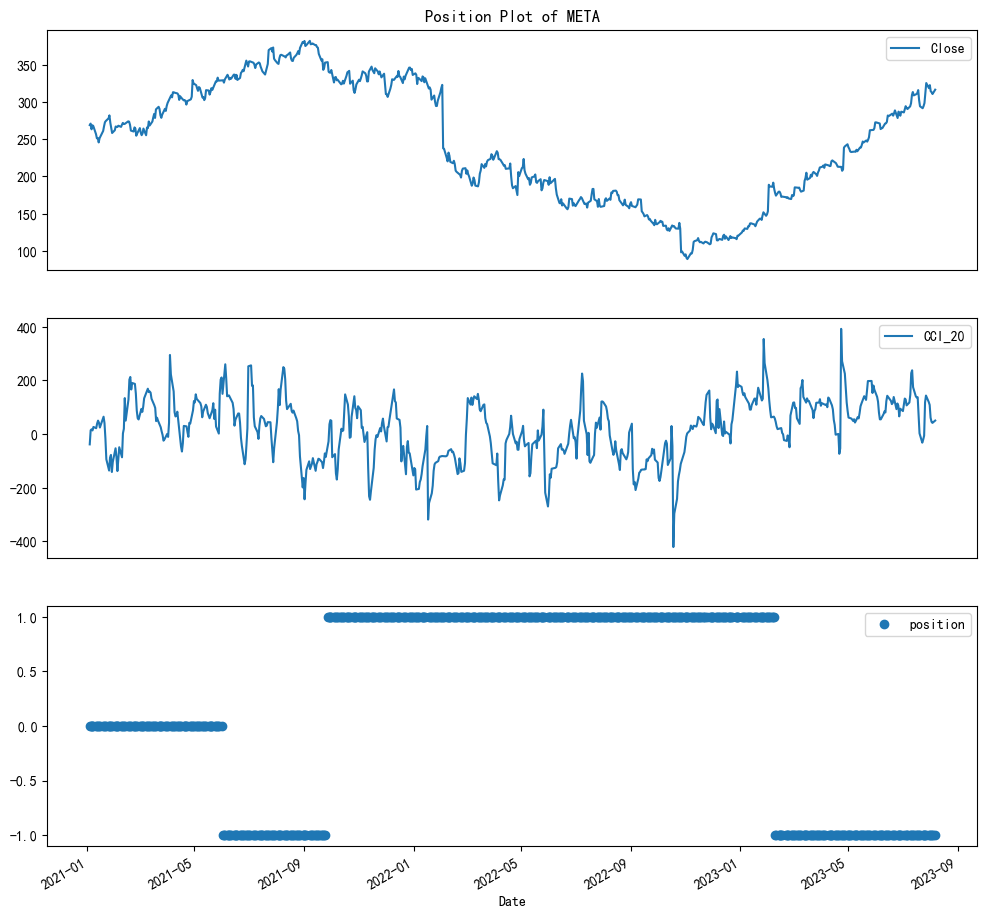

In [98]:
# Plot the position of META
plt.subplot(3, 1, 1)
plt.title('Position Plot of META')
plt.gca().axes.get_xaxis().set_visible(False)
stock_data['Close'].plot(figsize = (12,12))
plt.legend()

plt.subplot(3, 1, 2)
stock_data['CCI_20'].plot(figsize = (12,12))
plt.legend()
plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(3, 1, 3)
stock_data['position'].plot(marker='o', figsize=(12,12),linestyle='')
plt.legend()
plt.show()

### 4. Back Testing and Profit Results

In [99]:
# 计算策略收益
# 计算股票每日收益率
stock_data['pct_change'] = stock_data['Close'].pct_change()
# 计算策略每日收益率
stock_data['strategy_return'] = stock_data['pct_change'] * stock_data['position']
# 计算股票累积收益率
stock_data['return'] = (stock_data['pct_change']+1).cumprod()
# 计算策略累积收益率
stock_data['strategy_cum_return'] = (1 + stock_data['strategy_return']).cumprod()

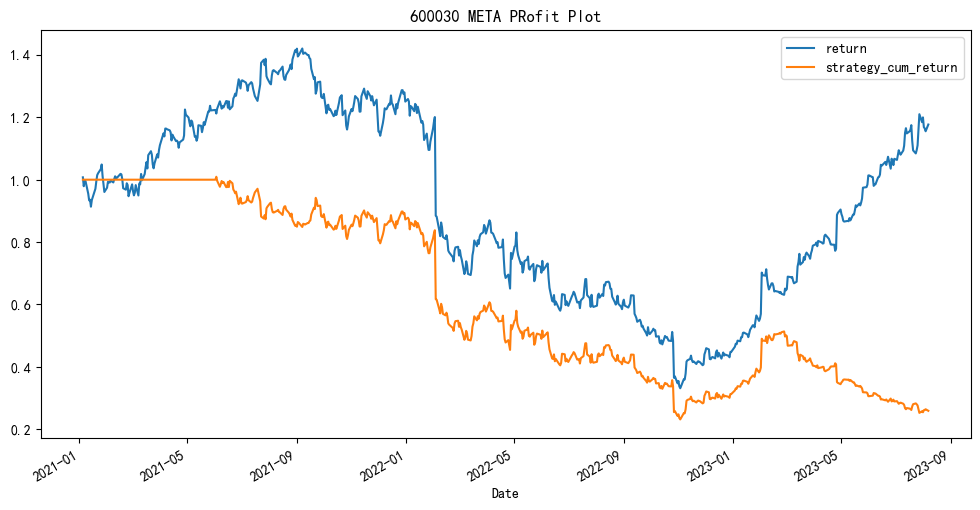

In [100]:
# Plot the total profit
stock_data[['return', 'strategy_cum_return']].plot(figsize = (12,6))

plt.title('600030 META PRofit Plot')
plt.legend()
plt.show()